In [1]:
import pandas as pd

In [2]:
file_path = 'csv/Online Retail.xlsx'
df = pd.read_excel(file_path, parse_dates=['InvoiceDate'])

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [5]:
# 4. Agrupar por cliente
customer = df.groupby('CustomerID').agg(
    frequency=('InvoiceNo', 'nunique'),
    total_revenue=('Revenue', 'sum'),
    monetary_value=('Revenue', 'mean'),
    first_purchase_date=('InvoiceDate', 'min'),
    last_purchase_date=('InvoiceDate', 'max')
).reset_index()

avg_lifespan = 12
margin = 0.1
max_date = df['InvoiceDate'].max()

customer['recency'] = (customer['last_purchase_date'] - customer['first_purchase_date'] ).dt.days
customer['T'] = (max_date - customer['first_purchase_date'] ).dt.days

customer['months'] = (customer['last_purchase_date'] - customer['first_purchase_date'] ).dt.days / 30
customer['avg_order_value'] = customer['total_revenue'] / customer['frequency']
customer['frequency_per_month'] = customer['frequency'] / customer['months'].replace(0, 1)
customer['CLV'] = customer['avg_order_value'] * customer['frequency_per_month'] * avg_lifespan * margin

customer.head()

,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,recency,T,months,avg_order_value,frequency_per_month,CLV
0,12346.0,1,77183.60,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,0,325,0.000000,77183.600000,1.000000,92620.320000
1,12347.0,7,4310.00,23.681319,2010-12-07 14:57:00,2011-12-07 15:52:00,365,366,12.166667,615.714286,0.575342,425.095890
2,12348.0,4,1797.24,57.975484,2010-12-16 19:09:00,2011-09-25 13:13:00,282,357,9.400000,449.310000,0.425532,229.434894
3,12349.0,1,1757.55,24.076027,2011-11-21 09:51:00,2011-11-21 09:51:00,0,18,0.000000,1757.550000,1.000000,2109.060000
4,12350.0,1,334.40,19.670588,2011-02-02 16:01:00,2011-02-02 16:01:00,0,309,0.000000,334.400000,1.000000,401.280000


In [6]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

### Lifetimes

In [7]:
# lifetimes exige frequency > 1 e monetary_value > 0
summary = customer[(customer['frequency'] > 1) & (customer['monetary_value'] > 0)]


In [8]:
summary.head()

,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,recency,T,months,avg_order_value,frequency_per_month,CLV
1,12347.0,7,4310.00,23.681319,2010-12-07 14:57:00,2011-12-07 15:52:00,365,366,12.166667,615.714286,0.575342,425.095890
2,12348.0,4,1797.24,57.975484,2010-12-16 19:09:00,2011-09-25 13:13:00,282,357,9.400000,449.310000,0.425532,229.434894
5,12352.0,8,2506.04,29.482824,2011-02-16 12:33:00,2011-11-03 14:37:00,260,296,8.666667,313.255000,0.923077,346.990154
9,12356.0,3,2811.43,47.651356,2011-01-18 09:50:00,2011-11-17 08:40:00,302,325,10.066667,937.143333,0.298013,335.137351
11,12358.0,2,1168.06,61.476842,2011-07-12 10:04:00,2011-12-08 10:26:00,149,150,4.966667,584.030000,0.402685,282.215839


In [9]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])


<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.11, alpha: 79.08, b: 2.46, r: 2.17>

In [10]:
summary['expected_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180,
    summary['frequency'],
    summary['recency'],
    summary['T']
)

In [11]:
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary['frequency'], summary['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 5.01, q: 1.74, v: 4.85>

In [12]:
summary['expected_avg_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

In [13]:
summary['clv_6m'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=6,          # horizonte em meses
    discount_rate=0.01
)


In [14]:
customer = customer.merge(
    summary[['CustomerID', 'clv_6m']],
    on='CustomerID',
    how='left'
)

customer.head()


,CustomerID,frequency,total_revenue,monetary_value,first_purchase_date,last_purchase_date,recency,T,months,avg_order_value,frequency_per_month,CLV,clv_6m
0,12346.0,1,77183.60,77183.600000,2011-01-18 10:01:00,2011-01-18 10:01:00,0,325,0.000000,77183.600000,1.000000,92620.320000,NaN
1,12347.0,7,4310.00,23.681319,2010-12-07 14:57:00,2011-12-07 15:52:00,365,366,12.166667,615.714286,0.575342,425.095890,82.598432
2,12348.0,4,1797.24,57.975484,2010-12-16 19:09:00,2011-09-25 13:13:00,282,357,9.400000,449.310000,0.425532,229.434894,128.781830
3,12349.0,1,1757.55,24.076027,2011-11-21 09:51:00,2011-11-21 09:51:00,0,18,0.000000,1757.550000,1.000000,2109.060000,NaN
4,12350.0,1,334.40,19.670588,2011-02-02 16:01:00,2011-02-02 16:01:00,0,309,0.000000,334.400000,1.000000,401.280000,NaN


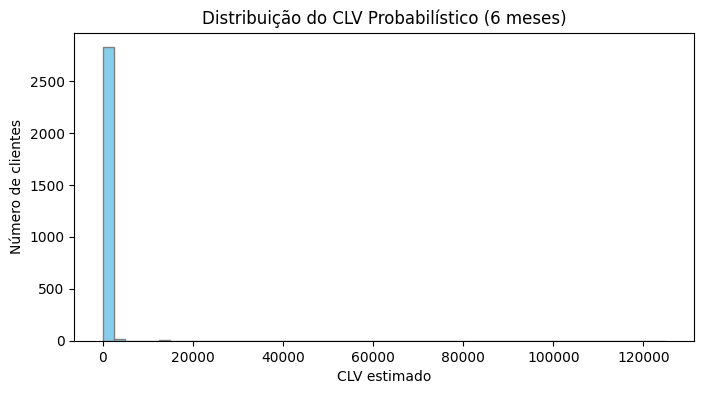

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(summary['clv_6m'], bins=50, color='skyblue', edgecolor='gray')
plt.title('Distribuição do CLV Probabilístico (6 meses)')
plt.xlabel('CLV estimado')
plt.ylabel('Número de clientes')
plt.show()


In [16]:
# Cria 4 segmentos (Q1 = menor CLV, Q4 = maior CLV)
summary['CLV_segment'] = pd.qcut(summary['clv_6m'], 4, labels=['Q1 - LOW', 'Q2 - MEDIUM', 'Q3 - HIGH', 'Q4 - TOP'])

# Resumo por segmento
segments = summary.groupby('CLV_segment').agg({
    'CustomerID': 'count',
    'frequency': 'mean',
    'monetary_value': 'mean',
    'expected_purchases_6m': 'mean',
    'clv_6m': 'mean',
    'CLV': 'mean'
}).rename(columns={'CustomerID': 'Clients'}).reset_index()

segments = segments.sort_index()
segments


,CLV_segment,Clients,frequency,monetary_value,expected_purchases_6m,clv_6m,CLV
0,Q1 - LOW,712,3.362360,12.328015,1.957959,17.807421,699.437907
1,Q2 - MEDIUM,711,4.037975,17.383842,3.124682,43.141232,349.028653
2,Q3 - HIGH,711,5.244726,21.097744,4.085430,74.252448,570.197493
3,Q4 - TOP,711,11.319269,178.965116,6.654876,611.603600,1356.362634
